In [16]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import os

# ---------------------
# 1. 데이터 처리 함수
# ---------------------
# create_sequences 함수는 시계열 데이터를 모델 학습에 적합한 입력-출력 시퀀스로 변환하는 역할
# 과거 seq_length 만큼의 데이터를 사용하여 다음 시점의 값을 예측하기 위해 사용
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length]) # X: 입력 시퀀스의 배열 (모델이 학습에 사용하는 과거 데이터) -> X는 2차원 배열임
        y.append(data[i+seq_length]) # y: 출력 값의 배열 (모델이 예측해야 하는 정답 데이터) -> y는 1차원 배열임
    return np.array(X), np.array(y)

def prepare_data(data, seq_length, batch_size):
    # 시퀀스 생성
    X, y = create_sequences(data, seq_length)
    # 차원 변환: (샘플수, 시퀀스길이, 특성수)
    X = X.reshape(-1, seq_length, 1) # X = (샘플수 x 시퀀스길이) -> (샘플수, 시퀀스길이, 특성수)
    y = y.reshape(-1, 1) # y = (샘플수) -> (샘플수 x 1)
    
    # 텐서로 변환 및 DataLoader 준비
    X_tensor = torch.from_numpy(X).float()
    y_tensor = torch.from_numpy(y).float()
    dataset = TensorDataset(X_tensor, y_tensor) # 입력 텐서(X_tensor)와 출력 텐서(y_tensor)를 하나의 데이터셋으로 묶는 작업
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader, X_tensor, y_tensor

#### reshape 메서드
- reshape은 배열의 형태(차원)를 바꿀 때 사용

- -1은 특정 차원의 크기를 자동으로 계산하도록 지시함
- 1은 해당 차원의 크기가 1임을 명시적으로 나타냄

i+seq_length 번째 값을 예측하기 위해 i부터 i+seq_length-1까지의 값을 사용

In [17]:
# ---------------------
# 2. LSTM 모델 정의
# ---------------------
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

h0과 c0는 각각 히든 레이어, 셀 스테이트 레이어
초기 레이어 노드값은 모두 0으로 초기화한다.

In [18]:
# ---------------------
# 3. 학습 함수
# ---------------------
def train_model(model, loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for inputs, targets in loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(loader):.4f}')

# ---------------------
# 4. 평가 함수
# ---------------------
def evaluate_model(model, X_tensor):
    model.eval()
    with torch.no_grad():
        predictions = model(X_tensor).squeeze().numpy()
    return predictions

In [19]:
# ---------------------
# 5. 시각화 함수
# ---------------------
def plot_results(actual_data, predictions, seq_length):
    plt.figure(figsize=(12,6))
    plt.plot(range(seq_length, len(actual_data)), actual_data[seq_length:], label='Actual')
    plt.plot(range(seq_length, len(actual_data)), predictions, label='Predicted')
    plt.legend()
    plt.title('LSTM Time Series Prediction')
    filepath = os.path.join("./outputs/", "plot.png")
    plt.savefig(filepath)
    plt.show()

Epoch [1/20], Loss: 0.3337
Epoch [2/20], Loss: 0.0376
Epoch [3/20], Loss: 0.0158
Epoch [4/20], Loss: 0.0138
Epoch [5/20], Loss: 0.0136
Epoch [6/20], Loss: 0.0134
Epoch [7/20], Loss: 0.0132
Epoch [8/20], Loss: 0.0125
Epoch [9/20], Loss: 0.0129
Epoch [10/20], Loss: 0.0131
Epoch [11/20], Loss: 0.0143
Epoch [12/20], Loss: 0.0136
Epoch [13/20], Loss: 0.0139
Epoch [14/20], Loss: 0.0131
Epoch [15/20], Loss: 0.0118
Epoch [16/20], Loss: 0.0121
Epoch [17/20], Loss: 0.0120
Epoch [18/20], Loss: 0.0120
Epoch [19/20], Loss: 0.0117
Epoch [20/20], Loss: 0.0119


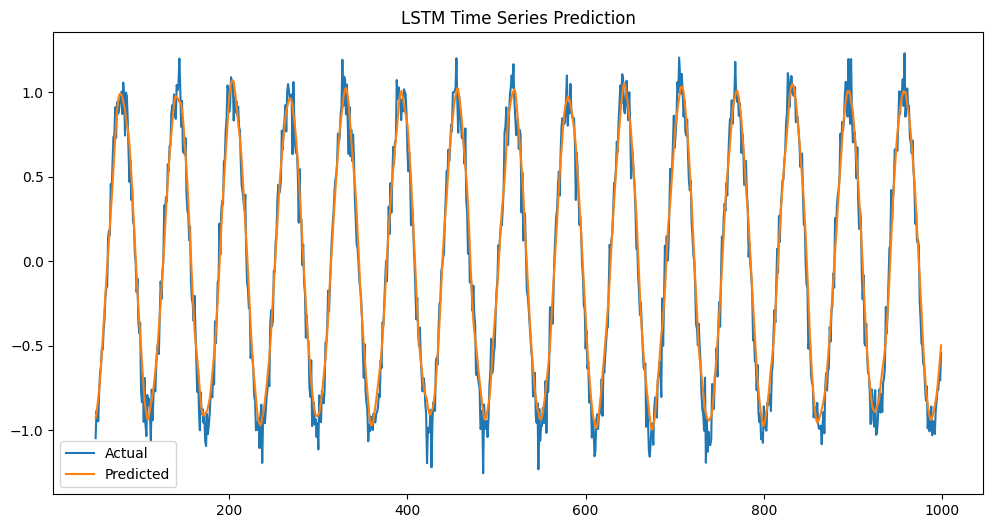

In [20]:
# ---------------------
# 메인 함수
# ---------------------
def main():
    # 데이터 생성 (예시: 노이즈가 있는 사인파)
    np.random.seed(0)
    time_steps = np.linspace(0, 100, 1000) # 0부터 100까지 1000개의 시간 스텝 
    #time_steps는 0초부터 100초까지의 시간 동안 일정 간격(약 0.1초)으로 측정된 시간 스텝
    data = np.sin(time_steps) + 0.1 * np.random.normal(size=len(time_steps)) # 사인파에 노이즈 추가
    
    # 하이퍼파라미터 설정
    sequence_length = 50
    batch_size = 32
    input_size = 1
    hidden_size = 64
    num_layers = 2
    output_size = 1
    learning_rate = 0.001
    num_epochs = 20

    # 데이터 준비
    loader, X_tensor, y_tensor = prepare_data(data, sequence_length, batch_size)

    # 모델, 손실함수, 옵티마이저 초기화
    model = LSTMModel(input_size, hidden_size, num_layers, output_size)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # 모델 학습
    train_model(model, loader, criterion, optimizer, num_epochs)

    # 평가 및 시각화
    predictions = evaluate_model(model, X_tensor)
    plot_results(data, predictions, sequence_length)

if __name__ == "__main__":
    main()
